In [101]:
# 2020-7-24 Janne Lehtonen, Xamk / Keskisuomalainen Oyj

# Churn-analysis with pandas using lifelines-library -- https://pypi.org/project/lifelines/

# This analysis is part of South-Eastern Finland UAS (Xamk) data-analytics BBA-program's practical internship period.
# It is made for Keskisuomalainen Oyj and the data is private.

# Data for analysis is from 'engage'-database, schema 'churn' using some data from 'payway'-schemas

# Data is from timeperiod 2019-6-1 to 2019-8-31

# Tools used with Python 3 are:
#
# Anaconda 1.9.12
# Jupyter Notebook 6.03
# pandas 1.0.3
# matplotlib 3.1.3
# lifelines 0.24.16

In [102]:
# Import all needed libraries.

# pandas is essential data-analytics library
import pandas as pd 

# lifelines-tools needed for survival analysis

from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times

# Shorten the KaplanMeierFitter-function

kmf = KaplanMeierFitter()

# matplolib needed for plotting

import matplotlib.pyplot as plt

# "When using the 'inline' backend, your matplotlib graphs will be included in your notebook, next to the code."
#  https://stackoverflow.com/questions/43027980/purpose-of-matplotlib-inline

%matplotlib inline

# Global settings for figure and label sizes

plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams['xtick.labelsize']=14
plt.rcParams['ytick.labelsize']=14

In [103]:
# Read file from path. r is for raw input, so you can just paste the path

data = pd.read_csv(r"C:\Users\lehtojan\Desktop\churn\churn_main.csv")

In [104]:
# Check the data, number value gives the amount of rows printed out

data.head(5)

,pa_cusno,pa_id,kayak_cusno,pa_gender,pa_marketing,papercode,campaign_number,campaign_name,start_date,stop_date,invoice_mode,invoice_value,subscription_kind,subs_name,receive_type,receive_value,package_type
0,5675039,5e8ad7fe22e0bc9a99306430,5675039,M,NaN,ETSA,78,"TARJOUSKESTO 3 KK 60,- KE (78)",2019-08-15,2700-01-01,6,Sähköposti,1,Kestotilaus,8,Puhelinmyynti,DIGI-PAPER COMBO
1,5770178,5abb990fa6720195b700c316,5770178,F,NaN,ETSA,78,"TARJOUSKESTO 3 KK 60,- KE (78)",2019-06-15,2019-08-06,1,Normaali,1,Kestotilaus,8,Puhelinmyynti,DIGI-PAPER COMBO
2,5695188,5c928e97ca96d6c6c8bbee84,5695188,M,"""""",ETSA,78,"TARJOUSKESTO 3 KK 60,- KE (78)",2019-06-08,2020-02-16,1,Normaali,1,Kestotilaus,8,Puhelinmyynti,DIGI-PAPER COMBO
3,5603362,5ab28e21996e5991fb0065e0,5603362,F,NaN,ETSA,78,"TARJOUSKESTO 3 KK 60,- KE (78)",2019-06-01,2019-08-31,1,Normaali,1,Kestotilaus,8,Puhelinmyynti,DIGI-PAPER COMBO
4,5555725,58e362b9bdf9281336015d7a,5555725,F,NaN,ETSA,78,"TARJOUSKESTO 3 KK 60,- KE (78)",2019-06-24,2700-01-01,1,Normaali,1,Kestotilaus,4,Internet,DIGI-PAPER COMBO


In [105]:
# Data types, note that start_date and stop_date are objects, not datetimes.

data.dtypes

pa_cusno              int64
pa_id                object
kayak_cusno           int64
pa_gender            object
pa_marketing         object
papercode            object
campaign_number       int64
campaign_name        object
start_date           object
stop_date            object
invoice_mode          int64
invoice_value        object
subscription_kind     int64
subs_name            object
receive_type          int64
receive_value        object
package_type         object
dtype: object

In [106]:
# Need to replace 2700-01-01 to 2100-01-01 since pandas won't recognize such date. 

data.replace('2700-01-01', '2100-01-01', inplace=True)

# Clean out pa_marketing since it has ""-entries, we'll assume they are not a marketing permission

data.replace('""', 'No', inplace=True)

In [107]:
# pa_marketing also has empty values. These are replaced here with No.

data["pa_marketing"].fillna("No", inplace = True) 

# Create conditional column. If pa_marketing value is 'No', then new column has value 'No'. If pa_marketing has any other
# value, then new column has value 'Yes'

data['marketing_ok'] = ['No' if x == 'No' else 'Yes' for x in data['pa_marketing']]

In [108]:
# Mark if there is 'death' observed. 1 means the customer has churned. Marking with 'E' as in event

data['E'] = ['0' if x == '2100-01-01' else '1' for x in data['stop_date']]

In [109]:
# Just checking the data

data.head(5)

,pa_cusno,pa_id,kayak_cusno,pa_gender,pa_marketing,papercode,campaign_number,campaign_name,start_date,stop_date,invoice_mode,invoice_value,subscription_kind,subs_name,receive_type,receive_value,package_type,marketing_ok,E
0,5675039,5e8ad7fe22e0bc9a99306430,5675039,M,No,ETSA,78,"TARJOUSKESTO 3 KK 60,- KE (78)",2019-08-15,2100-01-01,6,Sähköposti,1,Kestotilaus,8,Puhelinmyynti,DIGI-PAPER COMBO,No,0
1,5770178,5abb990fa6720195b700c316,5770178,F,No,ETSA,78,"TARJOUSKESTO 3 KK 60,- KE (78)",2019-06-15,2019-08-06,1,Normaali,1,Kestotilaus,8,Puhelinmyynti,DIGI-PAPER COMBO,No,1
2,5695188,5c928e97ca96d6c6c8bbee84,5695188,M,No,ETSA,78,"TARJOUSKESTO 3 KK 60,- KE (78)",2019-06-08,2020-02-16,1,Normaali,1,Kestotilaus,8,Puhelinmyynti,DIGI-PAPER COMBO,No,1
3,5603362,5ab28e21996e5991fb0065e0,5603362,F,No,ETSA,78,"TARJOUSKESTO 3 KK 60,- KE (78)",2019-06-01,2019-08-31,1,Normaali,1,Kestotilaus,8,Puhelinmyynti,DIGI-PAPER COMBO,No,1
4,5555725,58e362b9bdf9281336015d7a,5555725,F,No,ETSA,78,"TARJOUSKESTO 3 KK 60,- KE (78)",2019-06-24,2100-01-01,1,Normaali,1,Kestotilaus,4,Internet,DIGI-PAPER COMBO,No,0


In [110]:
# Convert start_date and stop_date from objects to datetimes

data['start_date'] = pd.to_datetime(data['start_date'])
data['stop_date'] = pd.to_datetime(data['stop_date'])

In [111]:
# After conversion, durations can now be calculated. 

data['T'] = (data['stop_date'] - data['start_date']).dt.days

In [112]:
# For some reason, there are negative durations in the data. This should convert them to zeroes.

#num = data._get_numeric_data()
#num[num < 0] = 0

In [113]:
data.head(20)

,pa_cusno,pa_id,kayak_cusno,pa_gender,pa_marketing,papercode,campaign_number,campaign_name,start_date,stop_date,invoice_mode,invoice_value,subscription_kind,subs_name,receive_type,receive_value,package_type,marketing_ok,E,T
0,5675039,5e8ad7fe22e0bc9a99306430,5675039,M,No,ETSA,78,"TARJOUSKESTO 3 KK 60,- KE (78)",2019-08-15,2100-01-01,6,Sähköposti,1,Kestotilaus,8,Puhelinmyynti,DIGI-PAPER COMBO,No,0,29359
1,5770178,5abb990fa6720195b700c316,5770178,F,No,ETSA,78,"TARJOUSKESTO 3 KK 60,- KE (78)",2019-06-15,2019-08-06,1,Normaali,1,Kestotilaus,8,Puhelinmyynti,DIGI-PAPER COMBO,No,1,52
2,5695188,5c928e97ca96d6c6c8bbee84,5695188,M,No,ETSA,78,"TARJOUSKESTO 3 KK 60,- KE (78)",2019-06-08,2020-02-16,1,Normaali,1,Kestotilaus,8,Puhelinmyynti,DIGI-PAPER COMBO,No,1,253
3,5603362,5ab28e21996e5991fb0065e0,5603362,F,No,ETSA,78,"TARJOUSKESTO 3 KK 60,- KE (78)",2019-06-01,2019-08-31,1,Normaali,1,Kestotilaus,8,Puhelinmyynti,DIGI-PAPER COMBO,No,1,91
4,5555725,58e362b9bdf9281336015d7a,5555725,F,No,ETSA,78,"TARJOUSKESTO 3 KK 60,- KE (78)",2019-06-24,2100-01-01,1,Normaali,1,Kestotilaus,4,Internet,DIGI-PAPER COMBO,No,0,29411
5,5604045,5bc845ea3694bf9419005843,5604045,F,No,ETSA,78,"TARJOUSKESTO 3 KK 60,- KE (78)",2019-07-27,2019-10-26,1,Normaali,1,Kestotilaus,8,Puhelinmyynti,DIGI-PAPER COMBO,No,1,91
6,5746821,5d539d6465501d7810001227,5746821,M,No,ETSA,78,"TARJOUSKESTO 3 KK 60,- KE (78)",2019-08-15,2019-11-25,1,Normaali,1,Kestotilaus,4,Internet,DIGI-PAPER COMBO,No,1,102
7,5589095,5a72941da672010a23000382,5589095,F,No,ETSA,78,"TARJOUSKESTO 3 KK 60,- KE (78)",2019-06-25,2019-12-30,1,Normaali,1,Kestotilaus,8,Puhelinmyynti,DIGI-PAPER COMBO,No,1,188
8,5599840,5aadbd4f60c1faa13100624c,5599840,F,No,ETSA,78,"TARJOUSKESTO 3 KK 60,- KE (78)",2019-08-28,2100-01-01,6,Sähköposti,1,Kestotilaus,8,Puhelinmyynti,DIGI-PAPER COMBO,No,0,29346
9,5687521,5d6e34bf22e0bcf97fcd4f19,5687521,M,No,ETSA,78,"TARJOUSKESTO 3 KK 60,- KE (78)",2019-08-17,2019-11-16,1,Normaali,1,Kestotilaus,8,Puhelinmyynti,DIGI-PAPER COMBO,No,1,91


In [114]:
# With this, you can drop values from columns. For example, there are few UNDEFINED entries in package_type,
# this gets rid of those.

data.drop(data.loc[data['package_type']=='UNDEFINED'].index, inplace=True)

In [115]:
# Count of subscribers by groups.

print('All subscribers:',data['pa_id'].count())
print()
print('Subscribers by', data.groupby('package_type')['pa_id'].count())
print()
print('Subscribers by', data.groupby('subs_name')['pa_id'].count())
print()
print('Subscribers by', data.groupby('papercode')['pa_id'].count())
print()
print('Subscribers by', data.groupby('pa_gender')['pa_id'].count())
print()
print('Subscribers by', data.groupby('invoice_value')['pa_id'].count())
print()
print('Subscribers by', data.groupby('receive_value')['pa_id'].count())
print()
print('Subscribers by', data.groupby('marketing_ok')['pa_id'].count())

All subscribers: 5576

Subscribers by package_type
DIGI-PAPER COMBO    2537
DIGITAL ONLY        2867
PAPER ONLY           172
Name: pa_id, dtype: int64

Subscribers by subs_name
Kestotilaus      2017
Määräaikainen    3559
Name: pa_id, dtype: int64

Subscribers by papercode
ES       701
ETSA     560
ITSA     452
KE      1285
KOSA     554
KYSA     490
LASA     436
SS       937
UUVU     161
Name: pa_id, dtype: int64

Subscribers by pa_gender
      103
F    3333
M    2140
Name: pa_id, dtype: int64

Subscribers by invoice_value
E-lasku                               576
Luottokortti kesto/määrä-aikainen     190
Normaali                             3525
Suoramaksu                             34
Sähköposti                            561
Verkkolasku (yritys)                  690
Name: pa_id, dtype: int64

Subscribers by receive_value
Internet                        1684
Mobiili                          141
Muu tarjouskirje                   1
PAYWAY                          1036
Puhelin        

In [116]:
# Shape of data (rows and columns), datatypes, note that E is an object. It should be numeric.

print(data.shape)
print(data.dtypes)

(5576, 20)
pa_cusno                      int64
pa_id                        object
kayak_cusno                   int64
pa_gender                    object
pa_marketing                 object
papercode                    object
campaign_number               int64
campaign_name                object
start_date           datetime64[ns]
stop_date            datetime64[ns]
invoice_mode                  int64
invoice_value                object
subscription_kind             int64
subs_name                    object
receive_type                  int64
receive_value                object
package_type                 object
marketing_ok                 object
E                            object
T                             int64
dtype: object


In [117]:
# Convert E from object to float

data['E'] = data.E.astype(float)

In [118]:
# Make T and E variables from respective columns. T is duration and E is event occurred, in this case customer has churned.

T = data['T']
E = data['E']

In [119]:
# KaplanMeierFitter, timeline to determine plot range. This starts from 0 days, ends at 400 days. 

kmf.fit(T, E, timeline=range(0,400,1))

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 5576 total observations, 1144 right-censored observations>

Median for churn is: 91.0


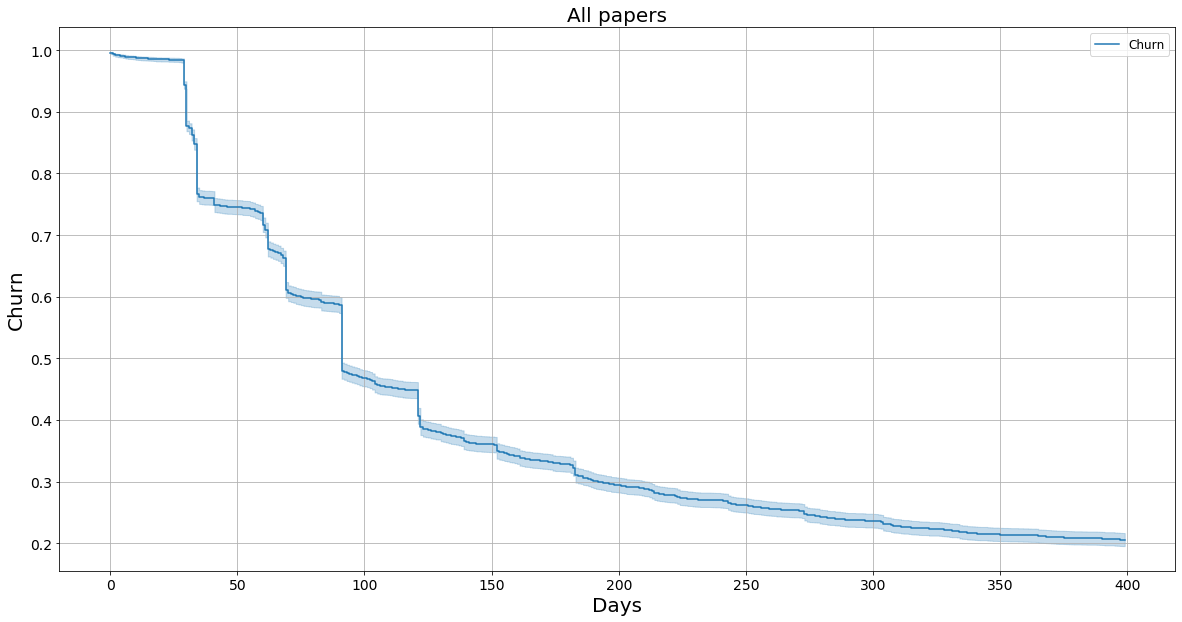

In [48]:
# Plotting the survival function for the whole data.

kmf.survival_function_
kmf.cumulative_density_

# Graphical parameters for the plot. Note that plot itself is ax variable.

ax1 = kmf.plot(label='Churn')

# Draws grid on the plot.

ax1.grid()

# Set y and x axes labels and font size

ax1.set_xlabel('Days', size = 20)
ax1.set_ylabel('Churn', size = 20)

# Set plot title and size

ax1.set_title('All papers', size = 20)

# Legend location and fontsize

ax1.legend(loc='upper right', fontsize = 12)

# Save the generated plot to file

plt.savefig(r'C:\Users\lehtojan\Desktop\churn\churn_all.png')

# Determining the median value for observed churn

median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)

# Print out the median with the plot

print("Median for churn is:",median_)

Digital sub median: 69.0
Digi-paper sub median: 128.0
Paper sub median: 183.0


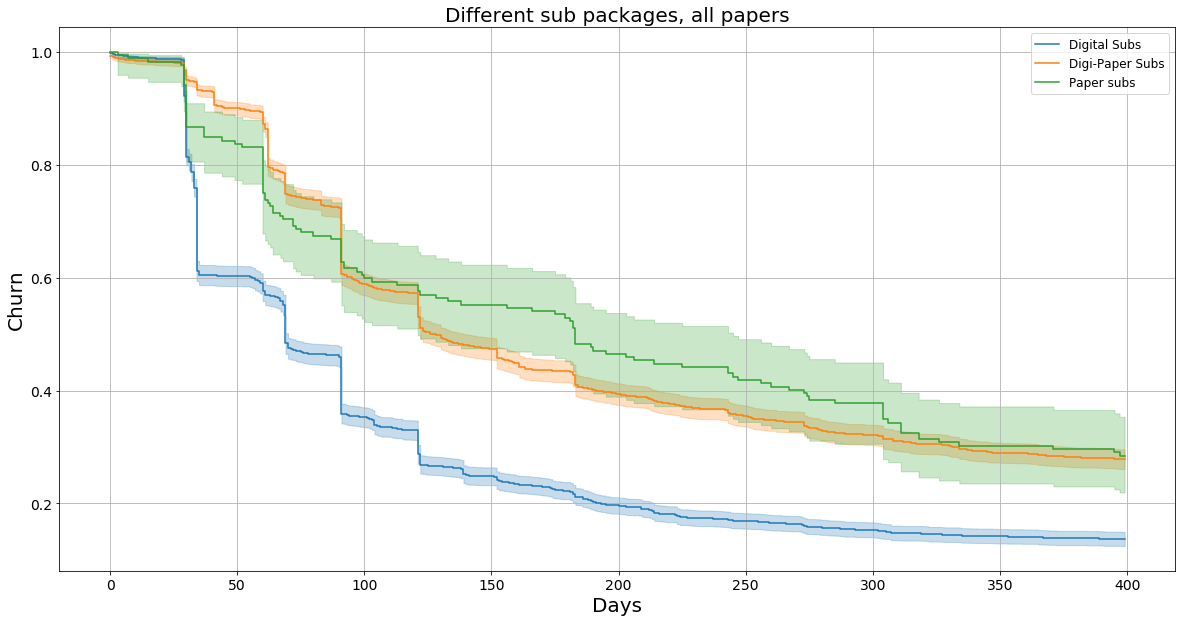

In [49]:
# Comparing different subscription packages.

# Plots subplot

ax = plt.subplot(111)

# Create variables for each value.

digi = (data["package_type"] == "DIGITAL ONLY")
digipap = (data["package_type"] == "DIGI-PAPER COMBO")
paper = (data["package_type"] == "PAPER ONLY")

# And fitting T and E variables to KaplanMeierFitter

kmf.fit(T[digi], event_observed=E[digi], label="Digital Subs", timeline=range(0,400,1))
kmf.plot(ax=ax)

# This calculates the median survival time. 

median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)

# Print out the median value.

print('Digital sub median:',median_)

# Fitting the second variable.

kmf.fit(T[digipap], event_observed=E[digipap], label="Digi-Paper Subs", timeline=range(0,400,1))
kmf.plot(ax=ax)

# Median calculation.

median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)

# And print.

print('Digi-paper sub median:',median_)

# Same for the third variable 'paper'

kmf.fit(T[paper], event_observed=E[paper], label="Paper subs", timeline=range(0,400,1))
kmf.plot(ax=ax)

median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)

print('Paper sub median:',median_)

# Graphical values for plot.

ax.grid()
ax.set_xlabel('Days', size = 20)
ax.set_ylabel('Churn', size = 20)
ax.set_title('Different sub packages, all papers', size = 20)
ax.legend(loc='upper right', fontsize = 12)

# Saves the figure as png

plt.savefig(r'C:\Users\lehtojan\Desktop\churn\churn_all_packages.png')

No marketing: 91.0
Marketing ok: 132.0


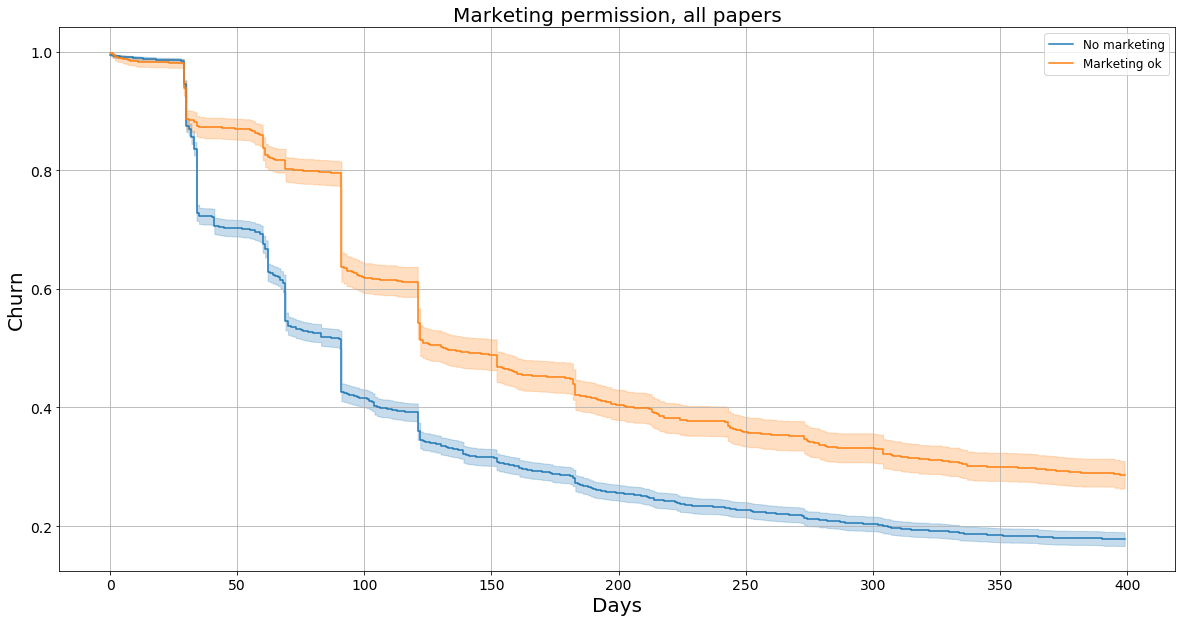

In [50]:
# Comparing if marketing permission has effect on churn. This is mostly the same as above cell, just with two variables.

ax = plt.subplot(111)

market_no = (data["marketing_ok"] == "No")
market_yes = (data["marketing_ok"] == "Yes")

kmf.fit(T[market_no], event_observed=E[market_no], label="No marketing", timeline=range(0,400,1))
kmf.plot(ax=ax)

median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)

print('No marketing:',median_)

kmf.fit(T[market_yes], event_observed=E[market_yes], label="Marketing ok", timeline=range(0,400,1))
kmf.plot(ax=ax)

median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)

print('Marketing ok:',median_)

ax.grid()
ax.set_xlabel('Days', size = 20)
ax.set_ylabel('Churn', size = 20)
ax.set_title('Marketing permission, all papers', size = 20)
ax.legend(loc='upper right', fontsize = 12)

plt.savefig(r'C:\Users\lehtojan\Desktop\churn\churn_all_marketing.png')

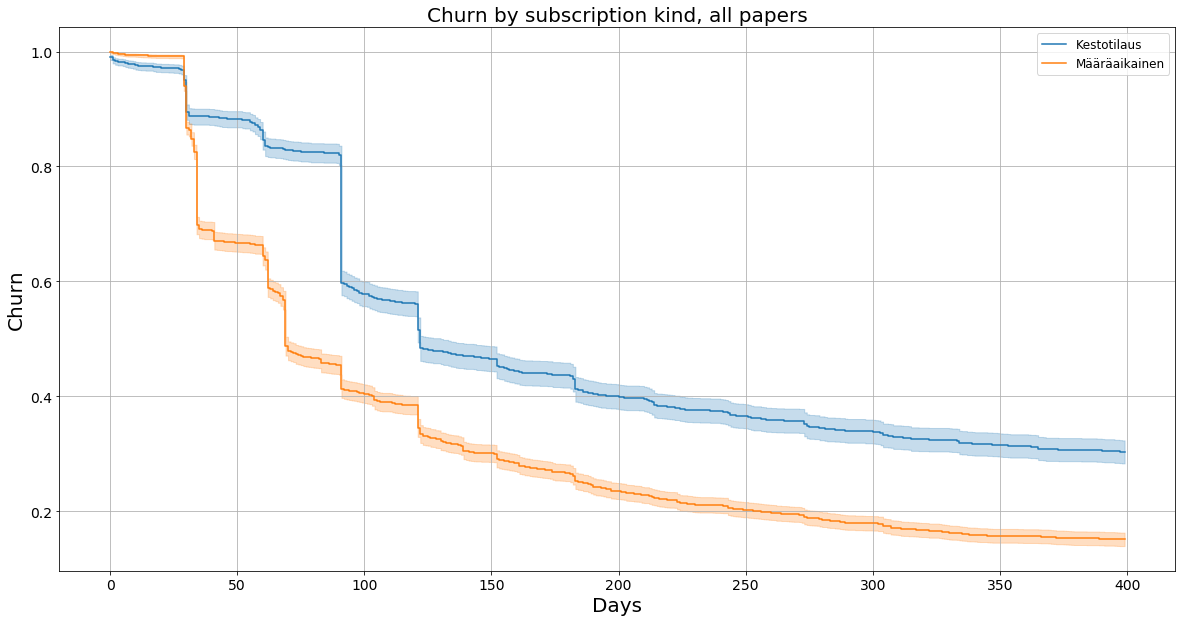

In [51]:
# Different kind of plotting. Here you can compare groups within columns.

ax = plt.subplot(111)

# This groups values from column.

for name, grouped_df in data.groupby('subs_name'):
    kmf.fit(grouped_df["T"], grouped_df["E"], label=name, timeline=range(0,400,1))
    kmf.plot(ax=ax)
    
ax.grid()
ax.set_xlabel('Days', size = 20)
ax.set_ylabel('Churn', size = 20)
ax.set_title('Churn by subscription kind, all papers', size = 20)
ax.legend(fontsize = 12)

plt.savefig(r'C:\Users\lehtojan\Desktop\churn\churn_all_subskind.png')

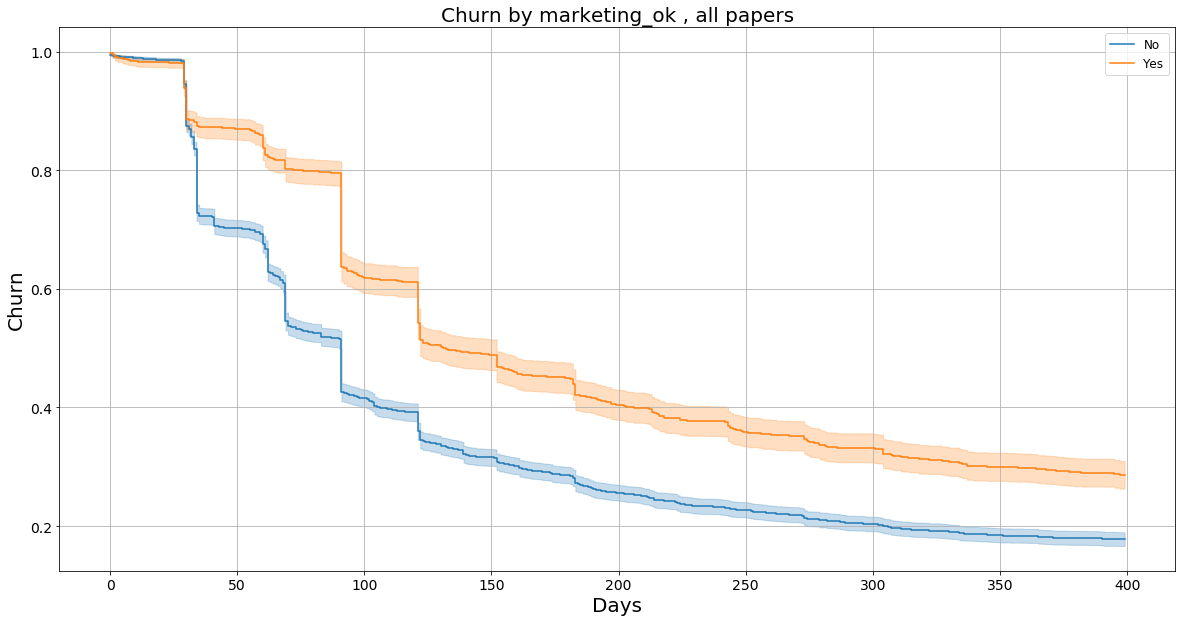

In [52]:
# Here you can compare churn in groups by changing the column name. All papers.

# Mostly the same as above cell, but here you just change the column-variable. No need to touch the code.
# Also, this saves the image with column name on it.

column = 'marketing_ok'

ax = plt.subplot(111)

for name, grouped_df in data.groupby(column):
    kmf.fit(grouped_df["T"], grouped_df["E"], label=name, timeline=range(0,400,1))
    kmf.plot(ax=ax)
    
ax.grid()
ax.set_xlabel('Days', size = 20)
ax.set_ylabel('Churn', size = 20)
ax.set_title('Churn by '+column+' , all papers', size = 20)
ax.legend(fontsize = 12)

plt.savefig(r'C:\Users\lehtojan\Desktop\churn\churn_'+column+'_allpapers.png')

Median churn is 91.0 days


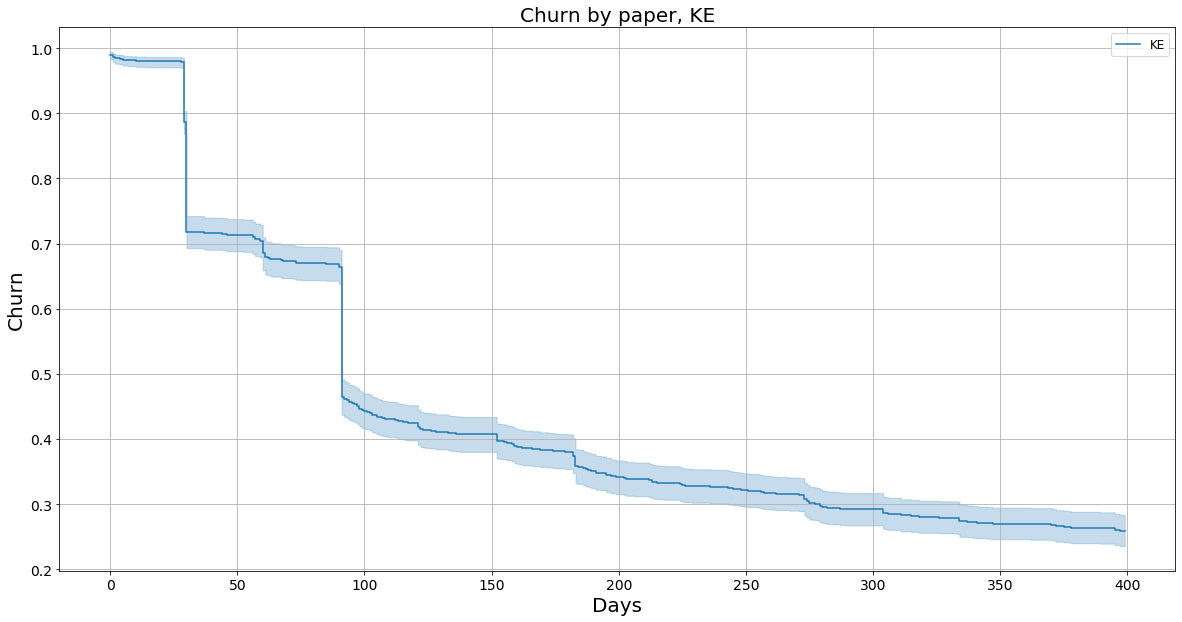

In [53]:
# Compare churn by paper. Change variable paper to papercode. With this, you can calculate the median values too.

paper = 'KE'

ax = plt.subplot(111)

lehti = (data["papercode"] == paper)

kmf.fit(T[lehti], event_observed=E[lehti], label=paper, timeline=range(0,400,1))
kmf.plot(ax=ax)

ax.grid()
ax.set_xlabel('Days', size = 20)
ax.set_ylabel('Churn', size = 20)
ax.set_title('Churn by paper, '+paper, size = 20)
ax.legend(loc='upper right', fontsize = 12)

median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)

print('Median churn is', median_,'days')

plt.savefig(r'C:\Users\lehtojan\Desktop\churn\churn_'+paper+'.png')

Median churn is 91.0 days


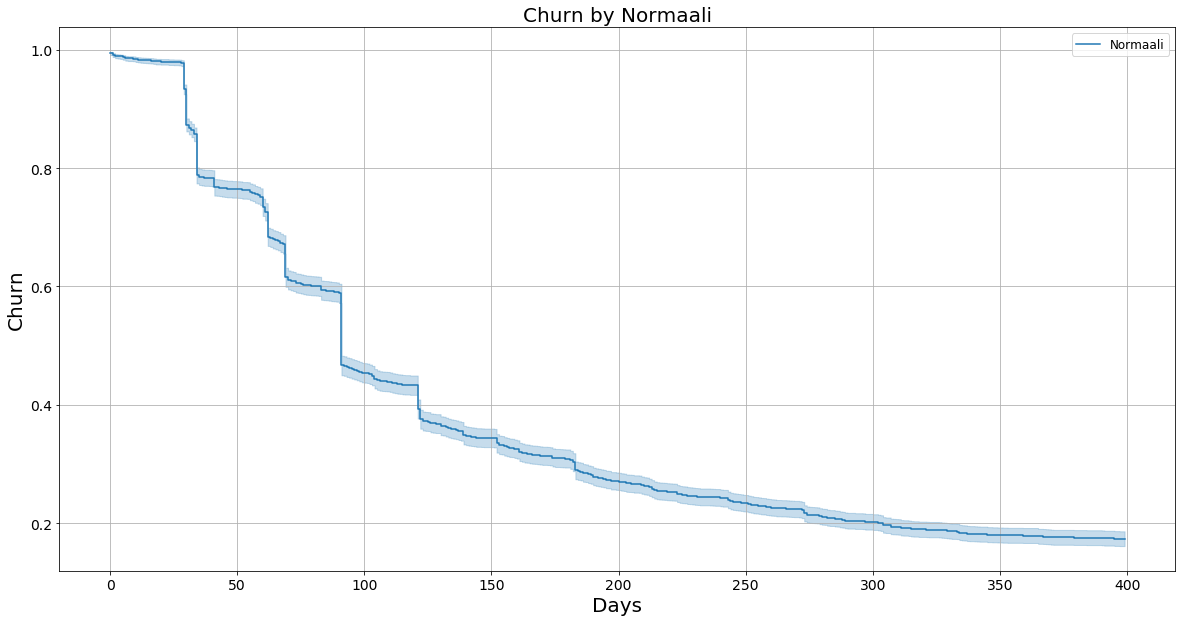

In [54]:
# Compare by invoice_value. Same as above cell, just variables changed.

invoice = 'Normaali'

ax = plt.subplot(111)

invtype = (data["invoice_value"] == invoice)

kmf.fit(T[invtype], event_observed=E[invtype], label=invoice, timeline=range(0,400,1))
kmf.plot(ax=ax)

ax.grid()
ax.set_xlabel('Days', size = 20)
ax.set_ylabel('Churn', size = 20)
ax.set_title('Churn by '+invoice, size = 20)
ax.legend(loc='upper right', fontsize = 12)

median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)

print('Median churn is', median_,'days')

plt.savefig(r'C:\Users\lehtojan\Desktop\churn\churn_invoice_'+invoice+'.png')

Median churn is inf days


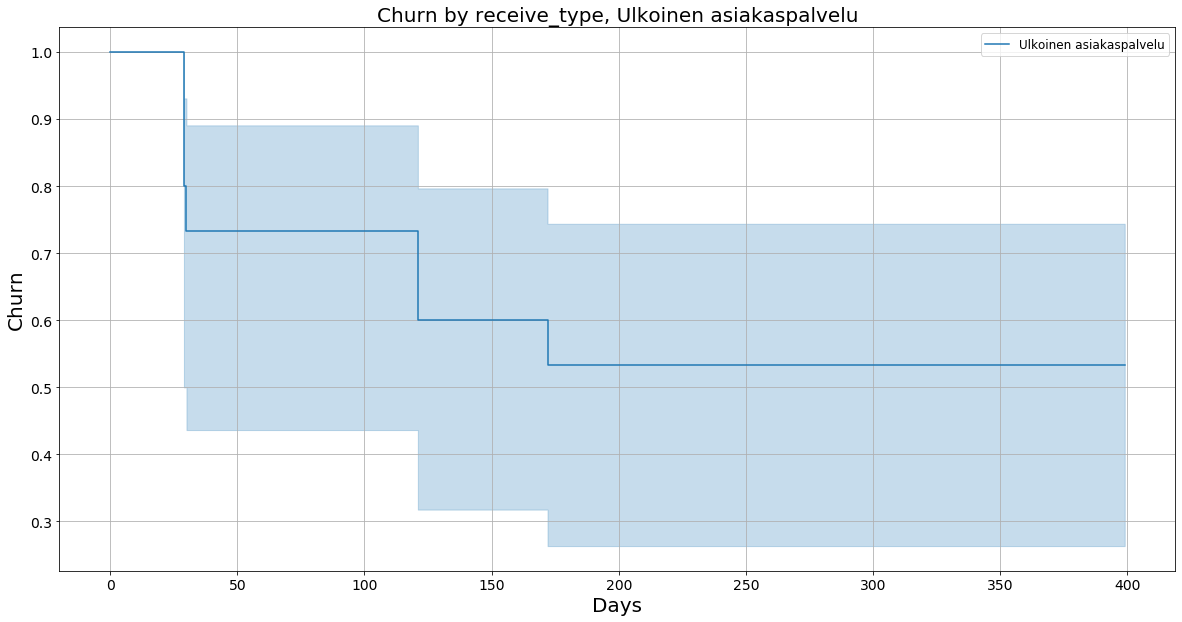

In [55]:
# Compare by receive_value. Again, same as above, just variables changed.

receive = 'Ulkoinen asiakaspalvelu'

ax = plt.subplot(111)

receivevalue = (data["receive_value"] == receive)

kmf.fit(T[receivevalue], event_observed=E[receivevalue], label=receive, timeline=range(0,400,1))
kmf.plot(ax=ax)

ax.grid()
ax.set_xlabel('Days', size = 20)
ax.set_ylabel('Churn', size = 20)
ax.set_title('Churn by receive_type, '+receive, size = 20)
ax.legend(loc='upper right', fontsize = 12)

median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)

print('Median churn is', median_,'days')

plt.savefig(r'C:\Users\lehtojan\Desktop\churn\churn_'+receive+'.png')

Median churn is 60.0 days


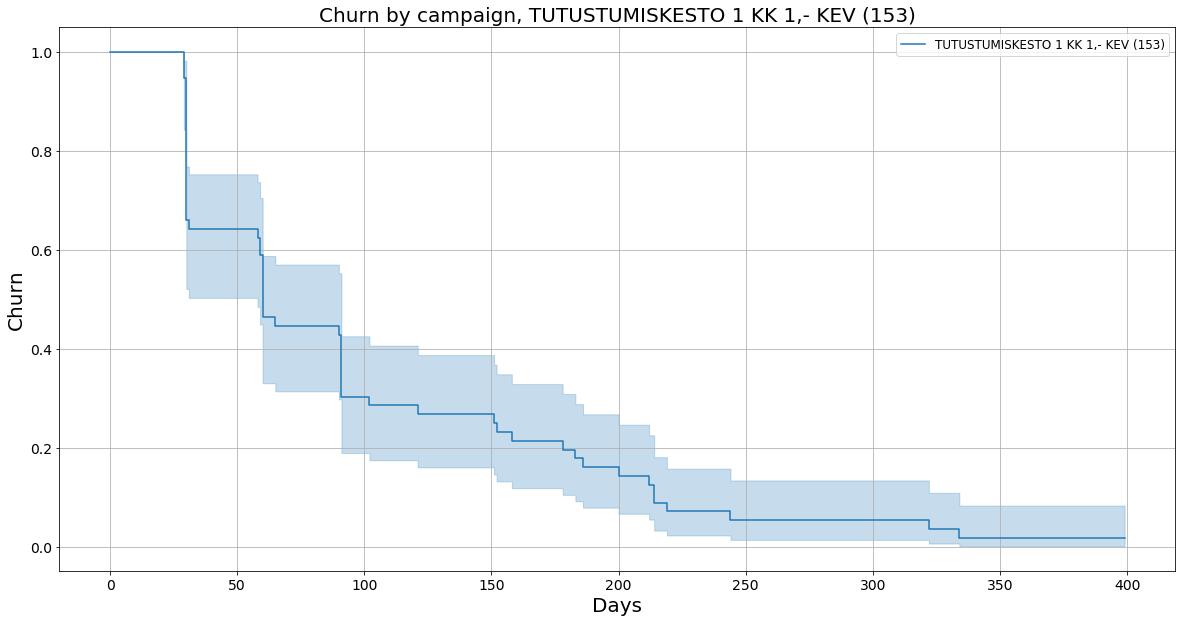

In [56]:
# This is for comparing different campaigns. There are large number of campaings in the current dataset. Campaings should be
# analysed by themselves, for example getting data for few interesting ones.

kampanja_name = 'TUTUSTUMISKESTO 1 KK 1,- KEV (153)'

ax = plt.subplot(111)

kampanja = (data["campaign_name"] == kampanja_name)

kmf.fit(T[kampanja], event_observed=E[kampanja], label=kampanja_name, timeline=range(0,400,1))
kmf.plot(ax=ax)

ax.grid()
ax.set_xlabel('Days', size = 20)
ax.set_ylabel('Churn', size = 20)
ax.set_title('Churn by campaign, '+kampanja_name, size = 20)
ax.legend(loc='upper right', fontsize = 12)

median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)

print('Median churn is', median_,'days')

plt.savefig(r'C:\Users\lehtojan\Desktop\churn\churn_campaign_'+kampanja_name+'.png')

Median is: 122.0


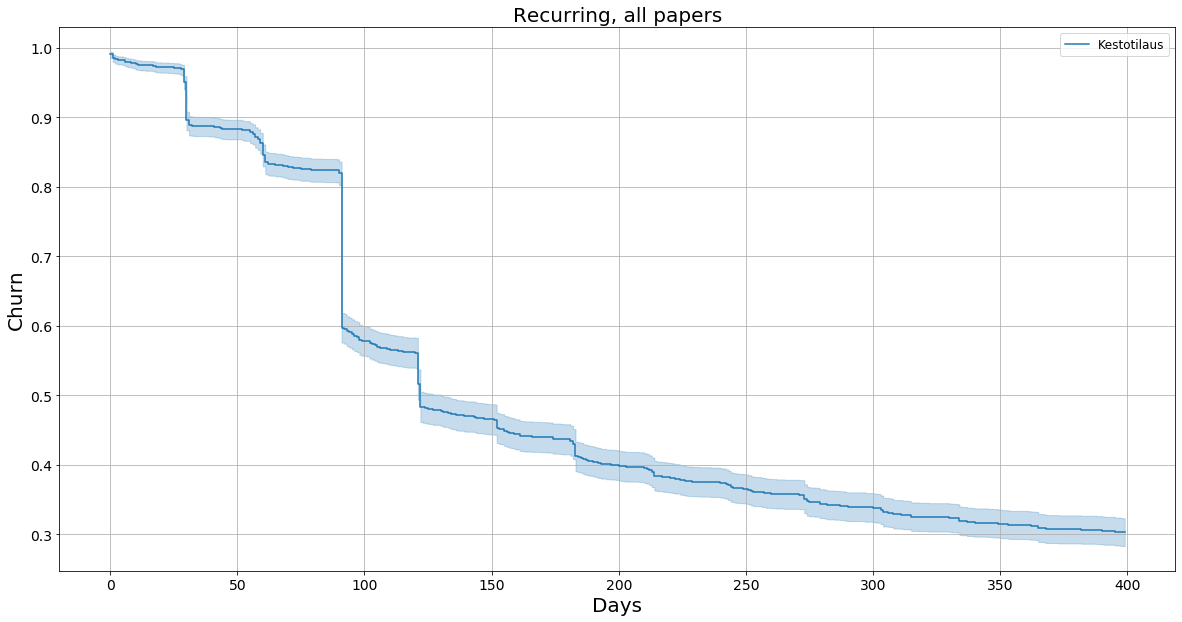

In [57]:
# Recurring subs for all papers

ax = plt.subplot(111)

tilaus = (data["subs_name"] == "Kestotilaus")

kmf.fit(T[tilaus], event_observed=E[tilaus], label="Kestotilaus", timeline=range(0,400,1))
kmf.plot(ax=ax)

ax.grid()
ax.set_xlabel('Days', size = 20)
ax.set_ylabel('Churn', size = 20)
ax.set_title('Recurring, all papers', size = 20)
ax.legend(loc='upper right', fontsize = 12)

median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)

plt.savefig(r'C:\Users\lehtojan\Desktop\churn\churn_recurring_allpapers.png')

print('Median is:',median_)

Median is: 69.0


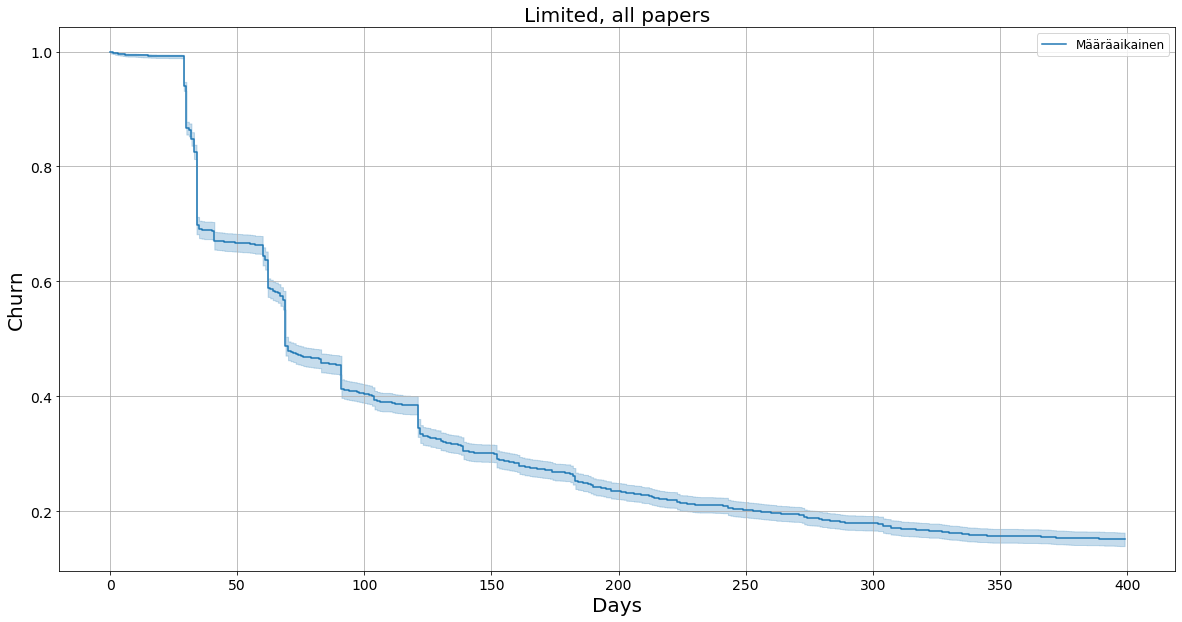

In [58]:
# Limited subs for all papers

ax = plt.subplot(111)

tilaus = (data["subs_name"] == "Määräaikainen")

kmf.fit(T[tilaus], event_observed=E[tilaus], label="Määräaikainen", timeline=range(0,400,1))
kmf.plot(ax=ax)

ax.grid()
ax.set_xlabel('Days', size = 20)
ax.set_ylabel('Churn', size = 20)
ax.set_title('Limited, all papers', size = 20)
ax.legend(loc='upper right', fontsize = 12)

median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)

plt.savefig(r'C:\Users\lehtojan\Desktop\churn\churn_limited_allpapers.png')

print('Median is:',median_)

In [59]:
# This saves the data with all modifications done to the path with filename.

data.to_csv(r'C:\Users\lehtojan\Desktop\churn\KSML_churn_modified.csv', index = False)

In [60]:
for col in data.columns: 
    print(col) 

pa_cusno
pa_id
kayak_cusno
pa_gender
pa_marketing
papercode
campaign_number
campaign_name
start_date
stop_date
invoice_mode
invoice_value
subscription_kind
subs_name
receive_type
receive_value
package_type
marketing_ok
E
T
